# TV Script Generation

This noteboook contains a text generator which works with a Recurrent Neural Network (RNN) based on LSTM units. The [Seinfeld Chronicles Dataset from Kaggle](https://www.kaggle.com/datasets/thec03u5/seinfeld-chronicles) is used, which contains the complete scripts from the [Seinfield TV Show](https://en.wikipedia.org/wiki/Seinfeld).

The project is a modification of the [Character-level RNN](https://github.com/karpathy/char-rnn) [implemented by Andrej Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/). I have used materials from the [Udacity Computer Vision Nanodegree](https://www.udacity.com/course/computer-vision-nanodegree--nd891), which can be obtained in their original form in [project-tv-script-generation](https://github.com/mxagar/deep-learning-v2-pytorch/tree/master/project-tv-script-generation).

If you're interested in the topic, I recommend you to read [my blog post on it](https://mikelsagardia.io/blog/text-generation-rnn.html), where I introduce Recurrent Neural Network (RNN) based on LSTM units and their application to language modeling.

Overview of contents:

- [1. Get the Data](#1.-Get-the-Data)
- [2. Explore the Data](#2.-Explore-the-Data)
- [3. Implement Pre-processing Functions](#3.-Implement-Pre-processing-Functions)
    - Lookup Table
    - Tokenize Punctuation
    - Pre-process all the data and save it
    - Checkpoint
- [4. Build the Data Loader](#4.-Build-the-Data-Loader)
    - Check Access to GPU
    - Input
    - Batching
    - Test your dataloader
- [5. Build the Neural Network](#5.-Build-the-Neural-Network)
    - Hints
    - Define forward and backpropagation
- [6. Neural Network Training](#6.-Neural-Network-Training)
    - Train loop
    - Hyperparameters
    - Check the output
    - Train
    - Discussion: how did we decide the model hyperparameters?
    - Checkpoint
- [7. Generate TV Script](#7.-Generate-TV-Script)
    - Generate Text Function
    - Generate a New Script


## 1. Get the Data

The data is already provided for you in `./data/Seinfeld_Scripts.txt` and you're encouraged to open that file and look at the text. 
>* As a first step, we'll load in this data and look at some samples. 
* Then, you'll be tasked with defining and training an RNN to generate a new script!

In [1]:
# load in data
import helper
data_dir = './data/Seinfeld_Scripts.txt'
text = helper.load_data(data_dir)

## 2. Explore the Data
Play around with `view_line_range` to view different parts of the data. This will give you a sense of the data you'll be working with. You can see, for example, that it is all lowercase text, and each new line of dialogue is separated by a newline character `\n`.

In [2]:
import numpy as np

view_line_range = (0, 10)

print('Dataset Stats')
# A temp dictionary is created with words as keys
print('Roughly the number of unique words: {}'.format(len({word: None for word in text.split()})))

lines = text.split('\n')
print('Number of lines: {}'.format(len(lines)))
word_count_line = [len(line.split()) for line in lines]
print('Average number of words in each line: {}'.format(np.average(word_count_line)))

Dataset Stats
Roughly the number of unique words: 46367
Number of lines: 109233
Average number of words in each line: 5.544240293684143


In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

Text(0.5,0,'Words in line')

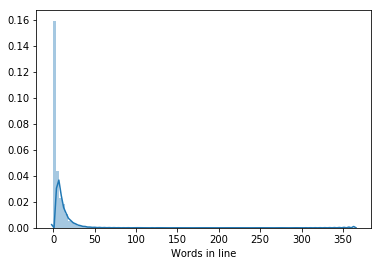

In [4]:
sns.distplot(word_count_line,bins=100)
plt.xlabel('Words in line')

In [5]:
print()
print('The lines {} to {}:'.format(*view_line_range))
# Each person line in the dialogues is separated by a new line,
# thus, we have effectively 2 lines per person-line.
print('\n'.join(text.split('\n')[view_line_range[0]:view_line_range[1]]))


The lines 0 to 10:
jerry: do you know what this is all about? do you know, why were here? to be out, this is out...and out is one of the single most enjoyable experiences of life. people...did you ever hear people talking about we should go out? this is what theyre talking about...this whole thing, were all out now, no one is home. not one person here is home, were all out! there are people trying to find us, they dont know where we are. (on an imaginary phone) did you ring?, i cant find him. where did he go? he didnt tell me where he was going. he must have gone out. you wanna go out you get ready, you pick out the clothes, right? you take the shower, you get all ready, get the cash, get your friends, the car, the spot, the reservation...then youre standing around, what do you do? you go we gotta be getting back. once youre out, you wanna get back! you wanna go to sleep, you wanna get up, you wanna go out again tomorrow, right? where ever you are in life, its my feeling, youve gotta 

## 3. Implement Pre-processing Functions
The first thing to do to any dataset is pre-processing.  Implement the following pre-processing functions below:
- Lookup Table
- Tokenize Punctuation

### Lookup Table
To create a word embedding, you first need to transform the words to ids.  In this function, create two dictionaries:
- Dictionary to go from the words to an id, we'll call `vocab_to_int`
- Dictionary to go from the id to word, we'll call `int_to_vocab`

Return these dictionaries in the following **tuple** `(vocab_to_int, int_to_vocab)`

In [6]:
from collections import Counter
import problem_unittests as tests

def create_lookup_tables(text):
    """
    Create lookup tables for vocabulary
    :param text: The text of tv scripts split into words
    :return: A tuple of dicts (vocab_to_int, int_to_vocab)
    """
    # Build a dictionary that maps words to integers and vice versa
    word_counts = Counter(text)
    words_sorted = list(sorted(word_counts,key=word_counts.get,reverse=True))
    offset = 0 # in case we want to reserve some integers
    int_to_vocab = {(i+offset):words_sorted[i] for i in range(len(words_sorted))}
    vocab_to_int = {words_sorted[i]:(i+offset) for i in range(len(words_sorted))}
    
    # Return tuple of dictionaries
    return (vocab_to_int, int_to_vocab)

tests.test_create_lookup_tables(create_lookup_tables)

Tests Passed


### Tokenize Punctuation
We'll be splitting the script into a word array using spaces as delimiters.  However, punctuations like periods and exclamation marks can create multiple ids for the same word. For example, "bye" and "bye!" would generate two different word ids.

Implement the function `token_lookup` to return a dict that will be used to tokenize symbols like "!" into "||Exclamation_Mark||".  Create a dictionary for the following symbols where the symbol is the key and value is the token:
- Period ( **.** )
- Comma ( **,** )
- Quotation Mark ( **"** )
- Semicolon ( **;** )
- Exclamation mark ( **!** )
- Question mark ( **?** )
- Left Parentheses ( **(** )
- Right Parentheses ( **)** )
- Dash ( **-** )
- Return ( **\n** )

This dictionary will be used to tokenize the symbols and add the delimiter (space) around it.  This separates each symbols as its own word, making it easier for the neural network to predict the next word. Make sure you don't use a value that could be confused as a word; for example, instead of using the value "dash", try using something like "||dash||".

In [7]:
def token_lookup():
    """
    Generate a dict to turn punctuation into a token.
    :return: Tokenized dictionary where the key is the punctuation and the value is the token
    """
    punctuation_tokens = {}
    punctuation_tokens['.'] = '||Period||'
    punctuation_tokens[','] = '||Comma||'
    punctuation_tokens['"'] = '||Quotation_Mark||'
    punctuation_tokens[';'] = '||Semicolon||'
    punctuation_tokens['!'] = '||Exclamation_Mark||'
    punctuation_tokens['?'] = '||Question_Mark||'
    punctuation_tokens['('] = '||Left_Parentheses||'
    punctuation_tokens[')'] = '||Right_Parentheses||'
    punctuation_tokens['-'] = '||Dash||'
    punctuation_tokens['\n'] = '||Return||'
    
    return punctuation_tokens

tests.test_tokenize(token_lookup)

Tests Passed


### Pre-process all the data and save it

Running the code cell below will pre-process all the data and save it to file. You're encouraged to lok at the code for `preprocess_and_save_data` in the `helpers.py` file to see what it's doing in detail, but you do not need to change this code.

In [8]:
# pre-process training data
helper.preprocess_and_save_data(data_dir, token_lookup, create_lookup_tables)

### Check Point
This is your first checkpoint. If you ever decide to come back to this notebook or have to restart the notebook, you can start from here. The preprocessed data has been saved to disk.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper
import problem_unittests as tests

int_text, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()

## 4. Build the Data Loader

In this section, you'll build the data loader, necessary to feed training samples to the RNN.

### Check Access to GPU

In [10]:
import torch

# Check for a GPU
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('No GPU found. Please use a GPU to train your neural network.')

### Input
Let's start with the preprocessed input data. We'll use [TensorDataset](http://pytorch.org/docs/master/data.html#torch.utils.data.TensorDataset) to provide a known format to our dataset; in combination with [DataLoader](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader), it will handle batching, shuffling, and other dataset iteration functions.

You can create data with TensorDataset by passing in feature and target tensors. Then create a DataLoader as usual.
```
data = TensorDataset(feature_tensors, target_tensors)
data_loader = torch.utils.data.DataLoader(data, 
                                          batch_size=batch_size)
```

### Batching
Implement the `batch_data` function to batch `words` data into chunks of size `batch_size` using the `TensorDataset` and `DataLoader` classes.

>You can batch words using the DataLoader, but it will be up to you to create `feature_tensors` and `target_tensors` of the correct size and content for a given `sequence_length`.

For example, say we have these as input:
```
words = [1, 2, 3, 4, 5, 6, 7]
sequence_length = 4
```

Your first `feature_tensor` should contain the values:
```
[1, 2, 3, 4]
```
And the corresponding `target_tensor` should just be the next "word"/tokenized word value:
```
5
```
This should continue with the second `feature_tensor`, `target_tensor` being:
```
[2, 3, 4, 5]  # features
6             # target
```

In [11]:
from torch.utils.data import TensorDataset, DataLoader

def batch_data(words, sequence_length, batch_size):
    """
    Batch the neural network data using DataLoader
    :param words: The word ids of the TV scripts
    :param sequence_length: The sequence length of each batch
    :param batch_size: The size of each batch; the number of sequences in a batch
    :return: DataLoader with batched data
    """
    # Convert to numpy
    words = np.array(words)
    
    # Initialize fetaures: each word gets a sequence with the items to its right
    # but we need to stop before sequence_length to allow having complete sequences
    features = np.zeros((words.shape[0]-sequence_length, sequence_length), dtype=int)
    # Targets are all words except the ones of the initial sequence
    targets = words[(sequence_length):]
    
    # Fill in the 2D array of feature words
    for row in range(features.shape[0]):
        features[row,:] = words[row:(row+sequence_length)]
    
    # Convert to Torch Tensors
    feature_tensors = torch.from_numpy(features)
    target_tensors = torch.from_numpy(targets)
    
    # Build dataloader
    data = TensorDataset(feature_tensors, target_tensors)
    data_loader = torch.utils.data.DataLoader(data,
                                              shuffle=True,
                                              batch_size=batch_size)
    # Return a dataloader
    return data_loader

# there is no test for this function, but you are encouraged to create
# print statements and tests of your own

### Test your dataloader 

You'll have to modify this code to test a batching function, but it should look fairly similar.

Below, we're generating some test text data and defining a dataloader using the function you defined, above. Then, we are getting some sample batch of inputs `sample_x` and targets `sample_y` from our dataloader.

Your code should return something like the following (likely in a different order, if you shuffled your data):

```
torch.Size([10, 5])
tensor([[ 28,  29,  30,  31,  32],
        [ 21,  22,  23,  24,  25],
        [ 17,  18,  19,  20,  21],
        [ 34,  35,  36,  37,  38],
        [ 11,  12,  13,  14,  15],
        [ 23,  24,  25,  26,  27],
        [  6,   7,   8,   9,  10],
        [ 38,  39,  40,  41,  42],
        [ 25,  26,  27,  28,  29],
        [  7,   8,   9,  10,  11]])

torch.Size([10])
tensor([ 33,  26,  22,  39,  16,  28,  11,  43,  30,  12])
```

#### Sizes
Your sample_x should be of size `(batch_size, sequence_length)` or (10, 5) in this case and sample_y should just have one dimension: batch_size (10). 

#### Values

You should also notice that the targets, sample_y, are the *next* value in the ordered test_text data. So, for an input sequence `[ 28,  29,  30,  31,  32]` that ends with the value `32`, the corresponding output should be `33`.

In [12]:
# test dataloader

test_text = range(50)
t_loader = batch_data(test_text, sequence_length=5, batch_size=10)

data_iter = iter(t_loader)
sample_x, sample_y = data_iter.next()

print(sample_x.shape)
print(sample_x)
print()
print(sample_y.shape)
print(sample_y)

torch.Size([10, 5])
tensor([[ 31,  32,  33,  34,  35],
        [ 22,  23,  24,  25,  26],
        [ 25,  26,  27,  28,  29],
        [  6,   7,   8,   9,  10],
        [  9,  10,  11,  12,  13],
        [ 42,  43,  44,  45,  46],
        [ 37,  38,  39,  40,  41],
        [ 43,  44,  45,  46,  47],
        [ 26,  27,  28,  29,  30],
        [ 23,  24,  25,  26,  27]])

torch.Size([10])
tensor([ 36,  27,  30,  11,  14,  47,  42,  48,  31,  28])


## 5. Build the Neural Network
Implement an RNN using PyTorch's [Module class](http://pytorch.org/docs/master/nn.html#torch.nn.Module). You may choose to use a GRU or an LSTM. To complete the RNN, you'll have to implement the following functions for the class:
 - `__init__` - The initialize function. 
 - `init_hidden` - The initialization function for an LSTM/GRU hidden state
 - `forward` - Forward propagation function.
 
The initialize function should create the layers of the neural network and save them to the class. The forward propagation function will use these layers to run forward propagation and generate an output and a hidden state.

**The output of this model should be the *last* batch of word scores** after a complete sequence has been processed. That is, for each input sequence of words, we only want to output the word scores for a single, most likely, next word.

### Hints

1. Make sure to stack the outputs of the lstm to pass to your fully-connected layer, you can do this with `lstm_output = lstm_output.contiguous().view(-1, self.hidden_dim)`
2. You can get the last batch of word scores by shaping the output of the final, fully-connected layer like so:

```
# reshape into (batch_size, seq_length, output_size)
output = output.view(batch_size, -1, self.output_size)
# get last batch
out = output[:, -1]
```

In [13]:
import torch.nn as nn

class RNN(nn.Module):
    
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_p=0.5):
        """
        Initialize the PyTorch RNN Module
        :param vocab_size: The number of input dimensions of the neural network (the size of the vocabulary)
        :param output_size: The number of output dimensions of the neural network
        :param embedding_dim: The size of embeddings, should you choose to use them        
        :param hidden_dim: The size of the hidden layer outputs
        :param dropout: dropout to add in between LSTM/GRU layers
        """
        super(RNN, self).__init__()
        
        # Set class variables
        self.vocab_size = vocab_size
        self.output_size = output_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.drop_p = drop_p
        self.batch_size = 1
        
        # Define model layers
        # - Embedding layer that turns words into a vector of a specified size
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        
        # - LSTM
        # batch_first=True:
        # in: (batch_size, seq_length, in_features/embedding_dim)
        # out: (batch_size, seq_length, out/hidden)
        self.lstm = nn.LSTM(self.embedding_dim,
                            self.hidden_dim,
                            self.n_layers, 
                            dropout=self.drop_p,
                            batch_first=True)
        
        # - Dropout layer
        self.dropout = nn.Dropout(self.drop_p*0.2)
        
        # - Final, fully-connected output layer
        self.fc = nn.Linear(self.hidden_dim, self.output_size)
        
        # - Log-Softmax / Softmax
        #self.log_softmax = nn.LogSoftmax(dim=1)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x, hidden):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network
        :param hidden: The hidden state        
        :return: Two Tensors, the output of the neural network and the latest hidden state
        """
        # Embedding
        x = x.long() # int64
        embed = self.embedding(x)
        
        # LSTM: Get the outputs and the new hidden state from the lstm
        lstm_out, hidden = self.lstm(embed, hidden)
        
        # lstm_out is of size
        # (batch_size, seq_length, out/hidden)
        # We want the output of the last words in seq
        lstm_out = lstm_out[:, -1, :] # getting the last time step output

        # Stack up LSTM outputs using view
        # before passing them to the MLP / Fully connected layer
        # We may need to use contiguous to reshape the output
        # .view does not copy or re-order the tensor elements,
        # it's just a view; with .contiguous() we re-order them in memory, too!
        # If we get a RunTimError related to view, try reshape or contiguous        
        out = lstm_out.contiguous().view(-1, self.hidden_dim) # (batch_size, hidden_dim)
        
        # Pass through a dropout layer
        out = self.dropout(out)
        
        # Put out through the fully-connected layer
        out = self.fc(out)
        
        # Log-Softmax / SoftMax
        #out = self.log_softmax(out) # a log-probability for each token in the vocabulary
        #out = self.softmax(out) # a probability for each token in the vocabulary
        
        # Return the final output and the hidden state
        return out, hidden    
    
    def init_hidden(self, batch_size):
        '''
        Initialize the hidden state of an LSTM/GRU
        :param batch_size: The batch_size of the hidden state
        :return: hidden state of dims (n_layers, batch_size, hidden_dim)
        '''
        # Initialize hidden state with zero weights, and move to GPU if available       
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        self.batch_size = batch_size
        weight = next(self.parameters()).data

        h = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
        c = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
        hidden = (h, c)
        
        if (train_on_gpu):
            hidden = (h.cuda(), c.cuda())
        
        return hidden

tests.test_rnn(RNN, train_on_gpu)

Tests Passed


### Define forward and backpropagation

Use the RNN class you implemented to apply forward and back propagation. This function will be called, iteratively, in the training loop as follows:
```
loss = forward_back_prop(decoder, decoder_optimizer, criterion, inp, target)
```

And it should return the average loss over a batch and the hidden state returned by a call to `RNN(inp, hidden)`. Recall that you can get this loss by computing it, as usual, and calling `loss.item()`.

**If a GPU is available, you should move your data to that GPU device, here.**

In [14]:
def forward_back_prop(net, optimizer, criterion, inputs, labels, hidden):
    """
    Forward and backward propagation on the neural network
    :param net: The PyTorch Module that holds the neural network
    :param optimizer: The PyTorch optimizer for the neural network
    :param criterion: The PyTorch loss function
    :param inputs: A batch of input to the neural network
    :param labels: The target output for the batch of input
    :return: The loss and the latest hidden state Tensor
    """
    # move data to GPU, if available
    if(train_on_gpu):
        net.cuda()
        inputs, labels = inputs.cuda(), labels.cuda()
    
    # perform backpropagation and optimization

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    hidden = tuple([each.data for each in hidden])

    # zero accumulated gradients
    net.zero_grad()

    # get the output from the model
    output, h = net(inputs, hidden)

    # calculate the loss and perform backprop
    # .squeeze(): remove empty dimensions
    # .float(): force 0s and 1s to be floats
    loss = criterion(output, labels.long())
    loss.backward()
    # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
    clip = 5
    nn.utils.clip_grad_norm_(net.parameters(), clip)
    optimizer.step()

    # return the loss over a batch and the hidden state produced by our model
    return loss.cpu().item(), h

# Note that these tests aren't completely extensive.
# they are here to act as general checks on the expected outputs of your functions
tests.test_forward_back_prop(RNN, forward_back_prop, train_on_gpu)

Tests Passed


## 6. Neural Network Training

With the structure of the network complete and data ready to be fed in the neural network, it's time to train it.

### Train Loop

The training loop is implemented for you in the `train_rnn` function. This function will train the network over all the batches for the number of epochs given. The model progress will be shown every number of batches. This number is set with the `show_every_n_batches` parameter. You'll set this parameter along with other parameters in the next section.

In [15]:
def train_rnn(rnn, batch_size, optimizer, criterion, n_epochs, show_every_n_batches=100):
    batch_losses = []
    
    rnn.train()

    print("Training for %d epoch(s)..." % n_epochs)
    for epoch_i in range(1, n_epochs + 1):
        
        # initialize hidden state
        hidden = rnn.init_hidden(batch_size)
        
        for batch_i, (inputs, labels) in enumerate(train_loader, 1):
            
            # make sure you iterate over completely full batches, only
            n_batches = len(train_loader.dataset)//batch_size
            if(batch_i > n_batches):
                break
            
            # forward, back prop
            loss, hidden = forward_back_prop(rnn, optimizer, criterion, inputs, labels, hidden)          
            # record loss
            batch_losses.append(loss)

            # printing loss stats
            if batch_i % show_every_n_batches == 0:
                print('Epoch: {:>4}/{:<4}  Loss: {}\n'.format(
                    epoch_i, n_epochs, np.average(batch_losses)))
                batch_losses = []

    # returns a trained rnn
    return rnn

In [16]:
"""
Another training function, but this time with validation
"""
# I modified the training function to include validation
# The reason is that I believe the model has many hyperparameters for the small dataset
# Thus, I need to keep track of the validation loss to avoid overfitting

def train_rnn_valid(rnn, batch_size, optimizer, criterion, n_epochs,
                  show_every_n_batches=100, validate=True):

    min_batch_valid_loss = np.Inf
    
    print("Training for %d epoch(s)..." % n_epochs)
    for epoch_i in range(1, n_epochs + 1):
        
        batch_train_losses = []
        rnn.train()
        
        # initialize hidden state
        hidden = rnn.init_hidden(batch_size)
        
        for batch_i, (inputs, labels) in enumerate(train_loader, 1):
            
            # make sure you iterate over completely full batches, only
            n_batches = len(train_loader.dataset)//batch_size
            if(batch_i > n_batches):
                break
            
            # forward, back prop
            loss, hidden = forward_back_prop(rnn, optimizer, criterion, inputs, labels, hidden)          
            # record loss
            #batch_losses.append(loss)
            batch_train_losses.append(loss)

            # printing loss stats
            if batch_i % show_every_n_batches == 0:
                print('\nEpoch: {:>4}/{:<4}  Avg. Train Batch Loss: {:.5f}'.format(
                    epoch_i, n_epochs, np.average(batch_train_losses)))
                if not validate:
                    batch_train_losses = []
                    
        if validate:
            rnn.eval()
            batch_valid_losses = []
            hidden = rnn.init_hidden(batch_size)
            for batch_i, (inputs, labels) in enumerate(valid_loader, 1):
                n_batches = len(valid_loader.dataset)//batch_size
                if (batch_i > n_batches):
                    break

                if (train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                with torch.no_grad():
                    hidden = tuple([each.data for each in hidden])
                    output, hidden = rnn(inputs, hidden)
                    loss = criterion(output, labels.long())

                batch_valid_losses.append(loss.cpu().item())

            print('\nEpoch: {:>4}/{:<4}  Train Loss: {:.5f}  Valid Loss: {:.5f}'.format(
                epoch_i, n_epochs, np.average(batch_train_losses), np.average(batch_valid_losses)))

            # Save if minimum loss in validation so far
            avg_valid_loss = np.average(batch_valid_losses)
            if avg_valid_loss < min_batch_valid_loss:
                print('Saving model...')
                helper.save_model('./models/trained_rnn_best', rnn)
                min_batch_valid_loss = avg_valid_loss
                
    # returns a trained rnn
    return rnn

### Hyperparameters

Set and train the neural network with the following parameters:
- Set `sequence_length` to the length of a sequence.
- Set `batch_size` to the batch size.
- Set `num_epochs` to the number of epochs to train for.
- Set `learning_rate` to the learning rate for an Adam optimizer.
- Set `vocab_size` to the number of unique tokens in our vocabulary.
- Set `output_size` to the desired size of the output.
- Set `embedding_dim` to the embedding dimension; smaller than the vocab_size.
- Set `hidden_dim` to the hidden dimension of your RNN.
- Set `n_layers` to the number of layers/cells in your RNN.
- Set `show_every_n_batches` to the number of batches at which the neural network should print progress.

If the network isn't getting the desired results, tweak these parameters and/or the layers in the `RNN` class.

#### Data Parameters

In [17]:
# Data params
# Sequence Length
sequence_length = 10 # 16
# Batch Size
batch_size = 128

# train/validation split
validation_ratio = 0.1
num_total_tokens = len(int_text)
num_valid_tokens = int(num_total_tokens*validation_ratio)
last_train_token = num_total_tokens-num_valid_tokens
print(last_train_token)

# data loader: train
#train_loader = batch_data(int_text, sequence_length, batch_size)
train_loader = batch_data(int_text[:last_train_token], sequence_length, batch_size)

# data loader: validation
valid_loader = batch_data(int_text[last_train_token:], sequence_length, batch_size)

802899


#### Check the DataLoader

In [18]:
n_batches = len(train_loader.dataset)//batch_size
print(f'Number of batches: {n_batches}')

Number of batches: 6272


In [19]:
data_iter = iter(train_loader)
sample_x, sample_y = data_iter.next()
print(sample_x.size())
print(sample_y.size())
print(sample_x)
print(sample_y)

torch.Size([128, 10])
torch.Size([128])
tensor([[   194,      2,      5,  ...,     20,     33,    290],
        [   701,    134,      1,  ...,      9,    521,      1],
        [    16,      5,   1076,  ...,   1064,     82,   3221],
        ...,
        [    10,    152,     25,  ...,     37,      5,     27],
        [     0,      7,      5,  ...,      1,      5,   7737],
        [    12,  19327,    308,  ...,   8675,      1,    455]])
tensor([     1,    198,      1,      1,     39,      2,     57,      1,
             4,      1,    374,     22,      0,      9,    370,     13,
           187,     12,      1,     42,     22,   1442,     15,      0,
           173,   6136,     76,     53,     41,     69,      9,    103,
            11,      0,      2,    125,    319,      1,     42,    517,
             1,      3,      2,     77,      4,    637,      2,    824,
            55,     13,      0,     19,      1,     17,    101,    475,
         17847,    188,      1,      0,      2,     91,   

#### Check int <-> token

In [20]:
common_tokens = [int_to_vocab[i] for i in range(10)]
#vocab_to_int
print(common_tokens)

['||return||', '||period||', '||comma||', '||question_mark||', 'you', 'i', 'the', 'jerry:', 'to', 'a']


In [21]:
# Number of unique tokens
len(vocab_to_int.keys())

21388

#### Training Parameters

In [22]:
# Training parameters
# Number of Epochs
num_epochs = 10
# Learning Rate
learning_rate = 0.001 # 0.003

# Model parameters
# Vocab size
vocab_size = len(vocab_to_int.keys())
# Output size
output_size = vocab_size
# Embedding Dimension
embedding_dim = 300
# Hidden Dimension
hidden_dim = 256
# Number of RNN Layers
n_layers = 2

# Show stats for every n number of batches
show_every_n_batches = 2000

#### Check Model Parameters

In [23]:
# The number of model parameters should not be much larger
# than the number of sequence items (words) in the dataset, otherwise we overfit.
# Best approach: define a model that is larger and apply droput to prevent overfitting;
# also, check validation error during training.
rnn = RNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_p=0.5)
print(rnn)
model_parameters = filter(lambda p: p.requires_grad, rnn.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f'Number of parameters: {params}')
print(f'Number of words in text {len(int_text)}')

RNN(
  (embedding): Embedding(21388, 300)
  (lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.1)
  (fc): Linear(in_features=256, out_features=21388, bias=True)
  (softmax): Softmax()
)
Number of parameters: 13010844
Number of words in text 892110


### Check the Output

In [24]:
rnn.eval()
criterion = nn.CrossEntropyLoss()

with torch.no_grad():

    hidden = rnn.init_hidden(batch_size)
    
    if (train_on_gpu):
        rnn.cuda()
        sample_x, sample_y = sample_x.cuda(), sample_y.cuda()

    hidden = tuple([each.data for each in hidden])

    output, h = rnn(sample_x, hidden)

    loss = criterion(output, sample_y.long())

    if (train_on_gpu):
        output = output.cpu()
        loss = loss.cpu()
    
    word_ints = output.argmax(dim=1)
    
    print(f'Loss: {loss.item()}')
    print(f'Size of the output: {output.size()}') # batch_size x vocabulary size
    print(f'Size of the labels: {sample_y.size()}') # batch_size x vocabulary size
    print(f'Size of predicted word ints: {word_ints.size()}')
    print(f'Predicted word-ints: {word_ints}')

Loss: 9.990155220031738
Size of the output: torch.Size([128, 21388])
Size of the labels: torch.Size([128])
Size of predicted word ints: torch.Size([128])
Predicted word-ints: tensor([ 13429,  10210,  12155,  10210,  19766,  17898,   8408,  12247,
         19640,  10210,  15297,   2466,  12612,  17678,   7497,   1073,
         14297,   8408,  16644,  10210,   3435,  17980,  18546,  20334,
         19640,  15155,   1567,  14297,  18253,  11073,  11957,  18985,
         14297,  18253,   8408,  17980,   5383,  15155,  15201,   1073,
          8392,   8408,  19024,   1088,   5809,  10210,   7614,   7105,
         20729,  14297,   8408,  14297,  12155,   4175,  12155,  17980,
         13481,  18253,  12593,   8408,  10764,  12155,   8408,   7614,
          5431,   1931,   1073,   2267,   3008,   8292,  13239,  12593,
          8408,  14681,   8408,  19664,  17314,  18985,  12593,  18509,
         17980,  19086,  18253,  12612,   7614,  20031,   8408,  13429,
         10210,  15156,   7392,  

### Train
In the next cell, you'll train the neural network on the pre-processed data.  If you have a hard time getting a good loss, you may consider changing your hyperparameters. In general, you may get better results with larger hidden and n_layer dimensions, but larger models take a longer time to train. 
> **You should aim for a loss less than 3.5.** 

You should also experiment with different sequence lengths, which determine the size of the long range dependencies that a model can learn.

In [25]:
#from workspace_utils import active_session
    
# create model and move to gpu if available
rnn = RNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_p=0.5)
if train_on_gpu:
    rnn.cuda()

# defining loss and optimization functions for training
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
#criterion = nn.NLLLoss()

# training the model
#with active_session():
#trained_rnn = train_rnn(rnn, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)
trained_rnn = train_rnn_valid(rnn, batch_size, optimizer, criterion, num_epochs, show_every_n_batches)

# saving the trained model
helper.save_model('./models/trained_rnn_last', trained_rnn)
print('Model Trained and Saved')

Training for 10 epoch(s)...

Epoch:    1/10    Avg. Train Batch Loss: 4.89623

Epoch:    1/10    Avg. Train Batch Loss: 4.63475

Epoch:    1/10    Avg. Train Batch Loss: 4.50194

Epoch:    1/10    Train Loss: 4.48887  Valid Loss: 4.39420
Saving model...


/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Epoch:    2/10    Avg. Train Batch Loss: 4.03707

Epoch:    2/10    Avg. Train Batch Loss: 4.02049

Epoch:    2/10    Avg. Train Batch Loss: 4.00022

Epoch:    2/10    Train Loss: 3.99966  Valid Loss: 4.36515
Saving model...

Epoch:    3/10    Avg. Train Batch Loss: 3.82523

Epoch:    3/10    Avg. Train Batch Loss: 3.82382

Epoch:    3/10    Avg. Train Batch Loss: 3.82487

Epoch:    3/10    Train Loss: 3.82640  Valid Loss: 4.39000

Epoch:    4/10    Avg. Train Batch Loss: 3.69228

Epoch:    4/10    Avg. Train Batch Loss: 3.70541

Epoch:    4/10    Avg. Train Batch Loss: 3.71405

Epoch:    4/10    Train Loss: 3.71598  Valid Loss: 4.42017

Epoch:    5/10    Avg. Train Batch Loss: 3.60675

Epoch:    5/10    Avg. Train Batch Loss: 3.62417

Epoch:    5/10    Avg. Train Batch Loss: 3.63729

Epoch:    5/10    Train Loss: 3.63963  Valid Loss: 4.44515

Epoch:    6/10    Avg. Train Batch Loss: 3.57874

Epoch:    6/10    Train Loss: 3.58099  Valid Loss: 4.48264

Epoch:    7/10    Avg. Train Batc

### Question: How did you decide on your model hyperparameters? 
For example, did you try different sequence_lengths and find that one size made the model converge faster? What about your hidden_dim and n_layers; how did you decide on those?

**Answer:** 

- `sequence_length`: I have tried values between `10-20` and I didn't experience large changes.
- `batch_size`: I have set the batch size large enough to take advantage of parallel computations, but not too big that we fall in local optima.
- `num_epochs`: 10 epochs have been enough to go below the required loss of `3.5`.
- `learning_rate`: the standard `0.001` has worked.
- `vocab_size`: the number of unique tokens in the vocabulary.
- `output_size`: the same as `vocab_size`, since we're trying to predict one-hot encoded tokens from the vocabulary.
- `embedding_dim`: I used the standard values between `200-300`.
- `hidden_dim`: after looking at similar examples (e.g., the Karpathy's character-level RNN), I have used a power of 2 around 200: `256`.
- `n_layers`: the recommended values are between `1-3`; I have used the middle point, which seems to work. More layers yield more complex models (with more paramaters), which are expensive to train and can overfit.

I have implemented a new extended training function which computes the loss with a validation split every epoch. Thanks to that function, we can see that the model overfits the train split. Some notes around that:

- To avoid overfitting, I added a dropout layer between the LSTM and the fully connected linear layer; however, the train loss increases considerably with large dropout probabilities. The current dropout value (0.1) allows low train losses, but the validation loss still increases with the number of epochs (so we are still overfitting).
- One could say that the train/validation split is not optimal: the vaidation split consists of the last 10% of the dataset, which corresponds to the last episodes of the TV show; that part is not necessarily representative of the series, i.e., the rest 90%.
- In the case of text generation, maybe we want to overfit: we want to generate text that resembles the training dataset.

### Checkpoint

After running the above training cell, your model will be saved by name, `trained_rnn`, and if you save your notebook progress, **you can pause here and come back to this code at another time**. You can resume your progress by running the next cell, which will load in our word:id dictionaries _and_ load in your saved model by name!

In [26]:
import torch
import helper
import problem_unittests as tests

_, vocab_to_int, int_to_vocab, token_dict = helper.load_preprocess()
trained_rnn = helper.load_model('./models/trained_rnn_last')
#trained_rnn = helper.load_model('./models/trained_rnn_best')

## 7. Generate TV Script
With the network trained and saved, you'll use it to generate a new, "fake" Seinfeld TV script in this section.

### Generate Text Function
To generate the text, the network needs to start with a single word and repeat its predictions until it reaches a set length. You'll be using the `generate` function to do this. It takes a word id to start with, `prime_id`, and generates a set length of text, `predict_len`. Also note that it uses topk sampling to introduce some randomness in choosing the most likely next word, given an output set of word scores!

In [30]:
import torch.nn.functional as F

def generate(rnn, prime_id, int_to_vocab, token_dict, pad_value, predict_len=100):
    """
    Generate text using the neural network
    :param decoder: The PyTorch Module that holds the trained neural network
    :param prime_id: The word id to start the first prediction
    :param int_to_vocab: Dict of word id keys to word values
    :param token_dict: Dict of puncuation tokens keys to puncuation values
    :param pad_value: The value used to pad a sequence
    :param predict_len: The length of text to generate
    :return: The generated text
    """
    rnn.eval()
    
    # create a sequence (batch_size=1) with the prime_id
    current_seq = np.full((1, sequence_length), pad_value)
    current_seq[-1][-1] = prime_id
    predicted = [int_to_vocab[prime_id]]
    
    for _ in range(predict_len):
        if train_on_gpu:
            current_seq = torch.LongTensor(current_seq).cuda()
        else:
            current_seq = torch.LongTensor(current_seq)
        
        # initialize the hidden state
        hidden = rnn.init_hidden(current_seq.size(0))
        
        # get the output of the rnn
        output, _ = rnn(current_seq, hidden)
        
        # get the next word probabilities
        p = F.softmax(output, dim=1).data
        if train_on_gpu:
            p = p.cpu() # move to cpu
         
        # use top_k sampling to get the index of the next word
        top_k = 5
        p, top_i = p.topk(top_k)
        top_i = top_i.numpy().squeeze()
        
        # select the likely next word index with some element of randomness
        p = p.numpy().squeeze()
        word_i = np.random.choice(top_i, p=p/p.sum())
        
        # retrieve that word from the dictionary
        word = int_to_vocab[word_i]
        predicted.append(word)     
        
        # the generated word becomes the next "current sequence" and the cycle can continue
        current_seq = np.roll(current_seq, -1, 1)
        current_seq[-1][-1] = word_i
    
    gen_sentences = ' '.join(predicted)
    
    # Replace punctuation tokens
    for key, token in token_dict.items():
        ending = ' ' if key in ['\n', '(', '"'] else ''
        gen_sentences = gen_sentences.replace(' ' + token.lower(), key)
    gen_sentences = gen_sentences.replace('\n ', '\n')
    gen_sentences = gen_sentences.replace('( ', '(')
    
    # return all the sentences
    return gen_sentences

### Generate a New Script
It's time to generate the text. Set `gen_length` to the length of TV script you want to generate and set `prime_word` to one of the following to start the prediction:
- "jerry"
- "elaine"
- "george"
- "kramer"

You can set the prime word to _any word_ in our dictionary, but it's best to start with a name for generating a TV script. (You can also start with any other names you find in the original text file!)

In [32]:
# run the cell multiple times to get different results!
gen_length = 400 # modify the length to your preference
prime_word = 'jerry' # name for starting the script

pad_word = helper.SPECIAL_WORDS['PADDING']
generated_script = generate(trained_rnn, vocab_to_int[prime_word + ':'], int_to_vocab, token_dict, vocab_to_int[pad_word], gen_length)
print(generated_script)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:61: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().


jerry:(jerry looks at the table)

george:(interrupting) i know.

jerry: i can't.

kramer:(pointing at the counter) hey, jerry, this is jerry.

kramer:(to jerry) i don't know.

jerry: oh, yeah.

jerry: oh, hi! i got a little taste in the middle of my life. i mean, i'm going to have the same one.

elaine: yeah, you know?

elaine:(to the phone) oh, you know, you can have to do this, we have the same one.

elaine: oh, my god.

jerry: hey. you know, i don't want a chance.

elaine: what?

elaine: i think it's not the same one. you know, you were a little concerned......... i was a little bit...

george: yeah..(to george) hey, i got a good news.

jerry: oh, you know, i don't know.

george: i know i was just curious. i know, i know, i would have to get the bathroom.

elaine:(to george) oh, yeah! i know that is so much.(they both laugh.)

elaine:(to jerry) hey jerry?

jerry:(pointing at his) i don't know.

elaine: i know.

george: oh, i don't know how you do.(he takes her hand)

jerry:(still sh

#### Save your favorite scripts

Once you have a script that you like (or find interesting), save it to a text file!

In [ ]:
# save script to a text file
f =  open("generated_script_1.txt","w")
f.write(generated_script)
f.close()

### The TV Script is Not Perfect
It's ok if the TV script doesn't make perfect sense. It should look like alternating lines of dialogue, here is one such example of a few generated lines.

### Example generated script

>jerry: what about me?
>
>jerry: i don't have to wait.
>
>kramer:(to the sales table)
>
>elaine:(to jerry) hey, look at this, i'm a good doctor.
>
>newman:(to elaine) you think i have no idea of this...
>
>elaine: oh, you better take the phone, and he was a little nervous.
>
>kramer:(to the phone) hey, hey, jerry, i don't want to be a little bit.(to kramer and jerry) you can't.
>
>jerry: oh, yeah. i don't even know, i know.
>
>jerry:(to the phone) oh, i know.
>
>kramer:(laughing) you know...(to jerry) you don't know.

You can see that there are multiple characters that say (somewhat) complete sentences, but it doesn't have to be perfect! It takes quite a while to get good results, and often, you'll have to use a smaller vocabulary (and discard uncommon words), or get more data.  The Seinfeld dataset is about 3.4 MB, which is big enough for our purposes; for script generation you'll want more than 1 MB of text, generally.